In [2]:
import time
import ipaddress
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [ ]:
def convert_ip2int(ip):
    try:
        return int(ipaddress.ip_address(ip))
    except ValueError:
        return 0  # Return 0 for invalid IP addresses    

def preprocess_data(data):
    df = data.copy()
    df.columns = df.columns.str.strip().str.replace('[ /]', '_', regex=True)
    
    df['Source_IP'] = df['Source_IP'].apply(convert_ip2int)
    df['Destination_IP'] = df['Destination_IP'].apply(convert_ip2int)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce').astype(np.int64)

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)

    y = np.where(df['Label'] == 'BENIGN', 0, 1)
    features_to_use = [
        'Source_IP',
        'Timestamp',
        'Avg_Bwd_Segment_Size',
        'Bwd_Packet_Length_Mean',
        'Bwd_Packet_Length_Std',
        'Destination_Port'
    ]

    X = df[features_to_use]
    return X, y

In [4]:
dataset_dir = './dataset'
csv_datasets = os.listdir(dataset_dir)
train_files = [f for f in csv_datasets if 'Wednesday' not in f]
test_files = [f for f in csv_datasets if 'Wednesday' in f]

# Load and concatenate training files
train_df_list = [pd.read_csv(os.path.join(dataset_dir, f), encoding='latin1', low_memory=False, on_bad_lines='skip' ) for f in train_files]
train_df = pd.concat(train_df_list, ignore_index=True)

# Load and concatenate testing files
test_df_list = [pd.read_csv(os.path.join(dataset_dir, f), encoding='latin1', low_memory=False, on_bad_lines='skip' ) for f in test_files]
test_df = pd.concat(test_df_list, ignore_index=True)

In [5]:
print("Preprocessing Train data...")
X_train, y_train = preprocess_data(train_df)
print("Preprocessing Test data...")
X_test, y_test = preprocess_data(test_df)

print("\n--- Data Shapes ---")
print(f"Train data shape: {X_train.shape}")
print(f"Test data shape:  {X_test.shape}")
print(f"Train labels distribution: Benign={np.sum(y_train==0)}, Attack={np.sum(y_train==1)}")
print(f"Test labels distribution:  Benign={np.sum(y_test==0)}, Attack={np.sum(y_test==1)}")


Preprocessing Train data...
Preprocessing Test data...

--- Data Shapes ---
Train data shape: (2426642, 6)
Test data shape:  (692703, 6)
Train labels distribution: Benign=1833066, Attack=593576
Test labels distribution:  Benign=440031, Attack=252672


In [6]:
RF_starttime = time.time()
# Initialize the model
RF_model = RandomForestClassifier(
    n_estimators=50, 
    max_depth=20, 
    min_samples_leaf=5, 
    random_state=42, 
    n_jobs=-1 # Use all available CPU cores
)

# Fit the model using the training data
RF_model.fit(X_train, y_train)
RF_endtime = time.time()
RF_time = RF_endtime - RF_starttime
print(f"Random Forest model training complete in {RF_time:.2f} seconds.")


Random Forest model training complete in 12.54 seconds.


In [7]:
print("\nEvaluating model performance on the Test set...")
# Predict on the separate test set
y_pred_RF = RF_model.predict(X_test)

accuracy_RF = accuracy_score(y_test, y_pred_RF)
recall_RF = recall_score(y_test, y_pred_RF)
f1_RF = f1_score(y_test, y_pred_RF)
report = classification_report(y_test, y_pred_RF, target_names=['BENIGN (0)', 'ATTACK (1)'])

print(f"\n--- Random Forest Results ---")
print(f"Accuracy: {accuracy_RF:.4f}")
print(f"Recall:   {recall_RF:.4f}")
print(f"F1-Score: {f1_RF:.4f}")
print("\nClassification Report:")
print(report)


Evaluating model performance on the Test set...

--- Random Forest Results ---
Accuracy: 0.8698
Recall:   0.6432
F1-Score: 0.7828

Classification Report:
              precision    recall  f1-score   support

  BENIGN (0)       0.83      1.00      0.91    440031
  ATTACK (1)       1.00      0.64      0.78    252672

    accuracy                           0.87    692703
   macro avg       0.91      0.82      0.84    692703
weighted avg       0.89      0.87      0.86    692703



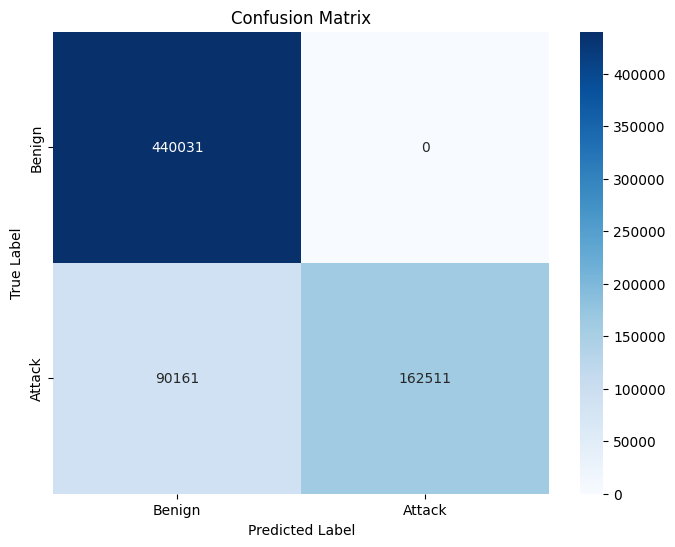

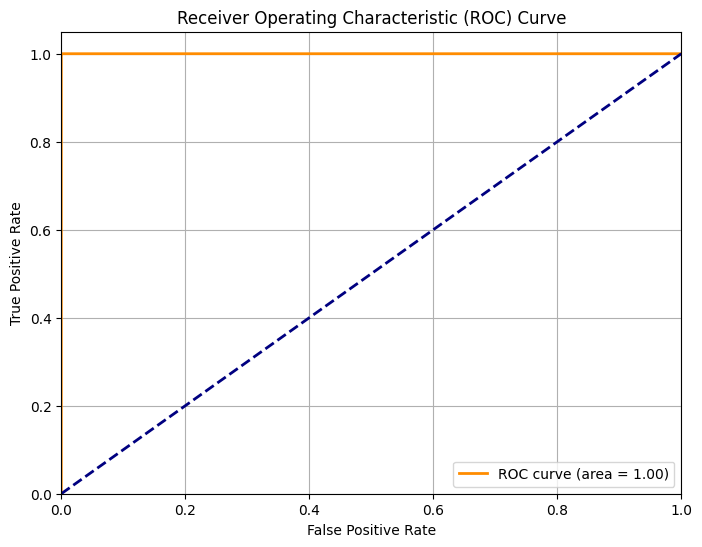

In [8]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_RF)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve
y_pred_proba = RF_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()